In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 256
use_gpu = True
y_scale = True
lr = 0.001
weight_decay = 0.01

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')


columns = X.columns


In [6]:
columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

## Imputer, Scaler, Feature selection

In [7]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)
X_test = X_test.drop(columns=['building_id'], axis=1)


### X sacle

In [9]:
X = pipeline.fit_transform(X)
print(X.shape)

X_test = pipeline.fit_transform(X_test)
print(X_test.shape)

(60000, 233)
(10000, 233)


In [10]:
#X = pd.DataFrame(X, columns=columns)

### y scale 

In [11]:
y_scaler = MinMaxScaler()
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [13]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 233])
torch.Size([10000, 233])
torch.Size([42000, 1])


In [15]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [16]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [17]:
model = DNN().to(device)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [18]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = torch.sqrt(criterion(pred, batch_y))
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = torch.sqrt(criterion(pred, batch_y))
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return np.array(eval_loss).mean()

def test_func(model, X):
    model.eval()
    
    with torch.no_grad():
        pred = model(X)
        pred = pred.cpu().numpy()
        
        if y_scale:
            pred = y_scaler.inverse_transform(pred)
            
    return pred


def accuracy(model, pct_close=0.5):
    #pred, y_eval
    model.eval()
    with torch.no_grad():
        pred = model(X_eval)
        
    n_correct = torch.sum((torch.abs(pred - y_eval) < torch.abs(pct_close * y_eval)))
    result = (n_correct.item()/len(y_eval))  # scalar
    return result 

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [19]:
train_losses = []
eval_losses = []
accs = []
for t in range(10000):
    print('epochs', t)
    train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        #acc = accuracy(model)
        
        eval_losses.append(eval_loss)
        train_losses.append(train_loss)
        
        #accs.append(acc)
        #print('accuracy: ',acc)

epochs 0
training loss 0.010236468137185456
epochs 1
training loss 0.006856219543877876
epochs 2
training loss 0.006817255973477255
epochs 3
training loss 0.006527737389798417
epochs 4
training loss 0.006384855528559648
epochs 5
training loss 0.006515893623035288
epochs 6
training loss 0.006325036013555346
epochs 7
training loss 0.006116098249472226
epochs 8
training loss 0.0059694397651279965
epochs 9
training loss 0.006409549346250115
testing loss 0.007083327271713232
epochs 10
training loss 0.006107296746675715
epochs 11
training loss 0.0059319667094810445
epochs 12
training loss 0.005761688123598244
epochs 13
training loss 0.0060034918641163545
epochs 14
training loss 0.00555215468277421
epochs 15
training loss 0.005642834039771873
epochs 16
training loss 0.005347476874224164
epochs 17
training loss 0.006079387998518844
epochs 18
training loss 0.005570409874516455
epochs 19
training loss 0.005683303936949056
testing loss 0.006118433782830834
epochs 20
training loss 0.00552991483021

training loss 0.0025851641386521584
epochs 169
training loss 0.0027568303500161025
testing loss 0.004811519968428347
epochs 170
training loss 0.002675302648408846
epochs 171
training loss 0.002376342358095854
epochs 172
training loss 0.0023788156675767494
epochs 173
training loss 0.0023980250313990945
epochs 174
training loss 0.002353251443216295
epochs 175
training loss 0.0028475522289447713
epochs 176
training loss 0.0030869750355398563
epochs 177
training loss 0.002682673837989569
epochs 178
training loss 0.0024538035772627954
epochs 179
training loss 0.0025194358034764954
testing loss 0.004778294847018911
epochs 180
training loss 0.0025417346500255394
epochs 181
training loss 0.00262489099775187
epochs 182
training loss 0.002413997568091321
epochs 183
training loss 0.0024742183374297437
epochs 184
training loss 0.002442200069499174
epochs 185
training loss 0.0023037076920666027
epochs 186
training loss 0.0025262469552795996
epochs 187
training loss 0.0025939707707783037
epochs 188


training loss 0.0016456555172970348
epochs 333
training loss 0.0016703927748356806
epochs 334
training loss 0.0017591465821941241
epochs 335
training loss 0.0019112937660379842
epochs 336
training loss 0.0019175756863798155
epochs 337
training loss 0.0017592415065419945
epochs 338
training loss 0.0016603073884845908
epochs 339
training loss 0.0017229279947721145
testing loss 0.003558274525755518
epochs 340
training loss 0.0016176044630507628
epochs 341
training loss 0.0016626019634052435
epochs 342
training loss 0.0014763316312437933
epochs 343
training loss 0.001878423026099688
epochs 344
training loss 0.0016874448502097617
epochs 345
training loss 0.0015425338085289255
epochs 346
training loss 0.0015278248924225795
epochs 347
training loss 0.0019285364281103918
epochs 348
training loss 0.0016255048812705685
epochs 349
training loss 0.0017590709513928178
testing loss 0.00375799618622052
epochs 350
training loss 0.0015682002197894634
epochs 351
training loss 0.0017045560885559428
epoch

training loss 0.0014926981537207735
epochs 497
training loss 0.0014171323534383467
epochs 498
training loss 0.0012885942009178866
epochs 499
training loss 0.0013012753707836522
testing loss 0.0032800962987788755
epochs 500
training loss 0.001409035204613412
epochs 501
training loss 0.0014360278915388114
epochs 502
training loss 0.0013604420403046816
epochs 503
training loss 0.0013372484266503967
epochs 504
training loss 0.001329504855499236
epochs 505
training loss 0.0013893613313098975
epochs 506
training loss 0.0014082729202610526
epochs 507
training loss 0.0016731556677823942
epochs 508
training loss 0.0014015648905611174
epochs 509
training loss 0.00135107106867839
testing loss 0.0034841837199129375
epochs 510
training loss 0.0013330635374807047
epochs 511
training loss 0.001793729781638831
epochs 512
training loss 0.0013924037921242416
epochs 513
training loss 0.0014805188684752493
epochs 514
training loss 0.0013049952008507468
epochs 515
training loss 0.0012650922007830532
epochs

training loss 0.001196731380751413
epochs 661
training loss 0.0011879594608520468
epochs 662
training loss 0.0011537306853852264
epochs 663
training loss 0.0011285227388284648
epochs 664
training loss 0.0012706633304443323
epochs 665
training loss 0.0012898133079888242
epochs 666
training loss 0.0012300414431868404
epochs 667
training loss 0.0012309666070381574
epochs 668
training loss 0.001215768256224692
epochs 669
training loss 0.0012663956138898025
testing loss 0.003292007728407658
epochs 670
training loss 0.0013390321365670498
epochs 671
training loss 0.0012289370127925366
epochs 672
training loss 0.0012190526305472084
epochs 673
training loss 0.0011541253615481159
epochs 674
training loss 0.001517178200425185
epochs 675
training loss 0.0013596797767659705
epochs 676
training loss 0.0011298517227370404
epochs 677
training loss 0.0013647219271991742
epochs 678
training loss 0.0012653566201951242
epochs 679
training loss 0.001448195857687317
testing loss 0.003482170045559465
epochs 

training loss 0.0011351541153889037
epochs 825
training loss 0.0009806167059154673
epochs 826
training loss 0.001154700542136914
epochs 827
training loss 0.0009887672615039981
epochs 828
training loss 0.0010143793738362464
epochs 829
training loss 0.001133444754646696
testing loss 0.003160411314907628
epochs 830
training loss 0.0012581220598693824
epochs 831
training loss 0.0011108076067599044
epochs 832
training loss 0.0011365668333107324
epochs 833
training loss 0.0012235423034960122
epochs 834
training loss 0.0011263135968792167
epochs 835
training loss 0.0011916626579918418
epochs 836
training loss 0.0010514603596124233
epochs 837
training loss 0.0010167603476227006
epochs 838
training loss 0.001137675083185913
epochs 839
training loss 0.0012869329184688853
testing loss 0.0038754704562474936
epochs 840
training loss 0.0012037948031458213
epochs 841
training loss 0.0011277839121634535
epochs 842
training loss 0.0011130276425374728
epochs 843
training loss 0.001073113993995569
epochs

training loss 0.0009812612848525697
epochs 989
training loss 0.0010533601218467635
testing loss 0.003165551862994235
epochs 990
training loss 0.001029379379046573
epochs 991
training loss 0.0011367087869792048
epochs 992
training loss 0.0010415233618749136
epochs 993
training loss 0.0010624682167403852
epochs 994
training loss 0.0011092204727571118
epochs 995
training loss 0.0010565435298662067
epochs 996
training loss 0.0009640484624965624
epochs 997
training loss 0.0010001775353554298
epochs 998
training loss 0.0011748638155757252
epochs 999
training loss 0.0011150215812394339
testing loss 0.0032486008155540053
epochs 1000
training loss 0.0009453134050338783
epochs 1001
training loss 0.0013453252218437917
epochs 1002
training loss 0.0011061020050846943
epochs 1003
training loss 0.0011639425760332609
epochs 1004
training loss 0.0010170511721464043
epochs 1005
training loss 0.0010203894263020518
epochs 1006
training loss 0.0010839001723621604
epochs 1007
training loss 0.001286196579034

training loss 0.001013120973242842
epochs 1149
training loss 0.0010191563679131143
testing loss 0.002841181492328014
epochs 1150
training loss 0.0009774753322937724
epochs 1151
training loss 0.0009880227530657342
epochs 1152
training loss 0.0011856777092554803
epochs 1153
training loss 0.0011184767259030857
epochs 1154
training loss 0.001214171708279261
epochs 1155
training loss 0.00156072416046465
epochs 1156
training loss 0.0010485515284182673
epochs 1157
training loss 0.001069021300821932
epochs 1158
training loss 0.0009530973297924819
epochs 1159
training loss 0.00103925586057206
testing loss 0.0031159012422660812
epochs 1160
training loss 0.0009209269809423748
epochs 1161
training loss 0.000916738488894859
epochs 1162
training loss 0.000825908408274479
epochs 1163
training loss 0.0009125478629192168
epochs 1164
training loss 0.0009537345232357356
epochs 1165
training loss 0.0010975205067855617
epochs 1166
training loss 0.001076120094071622
epochs 1167
training loss 0.0009581960141

training loss 0.0009725128148795303
epochs 1309
training loss 0.0009340342155403712
testing loss 0.00293138153149261
epochs 1310
training loss 0.0009039560152979737
epochs 1311
training loss 0.0009159664394136405
epochs 1312
training loss 0.0008792202552836952
epochs 1313
training loss 0.0009930962426799603
epochs 1314
training loss 0.0009426879985822421
epochs 1315
training loss 0.0008861965690316124
epochs 1316
training loss 0.0008861096600550368
epochs 1317
training loss 0.0009299890356928562
epochs 1318
training loss 0.0008865472504332887
epochs 1319
training loss 0.0008436433247742102
testing loss 0.0030333366791035613
epochs 1320
training loss 0.0008459438277041596
epochs 1321
training loss 0.0011862807804859724
epochs 1322
training loss 0.0011017823627105716
epochs 1323
training loss 0.0010586808167510862
epochs 1324
training loss 0.0009721199445652239
epochs 1325
training loss 0.0009781092274792943
epochs 1326
training loss 0.0008758926104443769
epochs 1327
training loss 0.0008

training loss 0.0008763062496048708
epochs 1469
training loss 0.0009018921699008029
testing loss 0.003022805250636761
epochs 1470
training loss 0.0008212400409816341
epochs 1471
training loss 0.0009369607365718394
epochs 1472
training loss 0.00096807258387068
epochs 1473
training loss 0.0010834426908386927
epochs 1474
training loss 0.0009200357849653245
epochs 1475
training loss 0.0009163350766440007
epochs 1476
training loss 0.0009056838964831761
epochs 1477
training loss 0.0008805842530405657
epochs 1478
training loss 0.0009172986677819581
epochs 1479
training loss 0.0009510018723438296
testing loss 0.003102701655785802
epochs 1480
training loss 0.0009547201045224387
epochs 1481
training loss 0.0009830383739123743
epochs 1482
training loss 0.0008375042054632848
epochs 1483
training loss 0.0011367607904090122
epochs 1484
training loss 0.0009987459733207342
epochs 1485
training loss 0.0008931932335888797
epochs 1486
training loss 0.0008712016278877854
epochs 1487
training loss 0.000862

training loss 0.0008094853023067117
epochs 1629
training loss 0.0008441860089078545
testing loss 0.003031242455185299
epochs 1630
training loss 0.0008416411445730112
epochs 1631
training loss 0.0008750077396998126
epochs 1632
training loss 0.0009313728319918455
epochs 1633
training loss 0.0008373694741308237
epochs 1634
training loss 0.0008338157052287099
epochs 1635
training loss 0.0009645664762832562
epochs 1636
training loss 0.0008729095602492717
epochs 1637
training loss 0.000869904041897054
epochs 1638
training loss 0.0009074435544651791
epochs 1639
training loss 0.0009753381420688873
testing loss 0.0031614541699191635
epochs 1640
training loss 0.0009434782448365833
epochs 1641
training loss 0.0009107224586786646
epochs 1642
training loss 0.0010467821767440799
epochs 1643
training loss 0.0008916299934781185
epochs 1644
training loss 0.0008734260999710496
epochs 1645
training loss 0.0008614334104949552
epochs 1646
training loss 0.000878704349143487
epochs 1647
training loss 0.00088

training loss 0.0009037677366215962
epochs 1789
training loss 0.000949419193520126
testing loss 0.0034108812032057575
epochs 1790
training loss 0.0009346910702967734
epochs 1791
training loss 0.0008945290344964825
epochs 1792
training loss 0.0009751135677409669
epochs 1793
training loss 0.0008444505412075104
epochs 1794
training loss 0.0009574650924398818
epochs 1795
training loss 0.0009388884250780172
epochs 1796
training loss 0.0009047639210510886
epochs 1797
training loss 0.0008416280540228454
epochs 1798
training loss 0.0009118598596559781
epochs 1799
training loss 0.0008607563876659807
testing loss 0.0031462003998327212
epochs 1800
training loss 0.0009796023354724502
epochs 1801
training loss 0.001060266785013179
epochs 1802
training loss 0.0008827383684657627
epochs 1803
training loss 0.0009181376719480437
epochs 1804
training loss 0.0008809214912947606
epochs 1805
training loss 0.0008793250086124648
epochs 1806
training loss 0.0008790792186504625
epochs 1807
training loss 0.0010

training loss 0.0008235318623271517
epochs 1949
training loss 0.0008245413412100099
testing loss 0.003220313820581306
epochs 1950
training loss 0.0009077467034909536
epochs 1951
training loss 0.0008265261584187322
epochs 1952
training loss 0.0008505636586271453
epochs 1953
training loss 0.0008900214632211083
epochs 1954
training loss 0.0007946434720052462
epochs 1955
training loss 0.000914940677202222
epochs 1956
training loss 0.0007962483828040687
epochs 1957
training loss 0.0008840085190692634
epochs 1958
training loss 0.0007593366380950267
epochs 1959
training loss 0.000853976477854744
testing loss 0.00331582609747707
epochs 1960
training loss 0.0012064837434357315
epochs 1961
training loss 0.0009969343145547266
epochs 1962
training loss 0.0008905043709091842
epochs 1963
training loss 0.0008245145228239849
epochs 1964
training loss 0.0009872181921364797
epochs 1965
training loss 0.0008079066272881447
epochs 1966
training loss 0.0009349753485752665
epochs 1967
training loss 0.0008793

training loss 0.0009281861458227716
epochs 2109
training loss 0.0008462198237380521
testing loss 0.003263671447942689
epochs 2110
training loss 0.0009383104554603271
epochs 2111
training loss 0.0008757479291296367
epochs 2112
training loss 0.00093368626249051
epochs 2113
training loss 0.0009868343815800141
epochs 2114
training loss 0.000891052902972495
epochs 2115
training loss 0.0007837425300033029
epochs 2116
training loss 0.0008206756035867852
epochs 2117
training loss 0.0008931661455073591
epochs 2118
training loss 0.0008327544991378531
epochs 2119
training loss 0.0009847649986940352
testing loss 0.003060168217749558
epochs 2120
training loss 0.0008240877290848981
epochs 2121
training loss 0.000775978222637522
epochs 2122
training loss 0.0008980028849857098
epochs 2123
training loss 0.000825655997632015
epochs 2124
training loss 0.0008990322945244385
epochs 2125
training loss 0.0008748729547457488
epochs 2126
training loss 0.0007583046360223583
epochs 2127
training loss 0.000792248

training loss 0.0008534525870345533
epochs 2269
training loss 0.0009713983459567482
testing loss 0.003186110567799966
epochs 2270
training loss 0.0008773125401190058
epochs 2271
training loss 0.0008476895793468099
epochs 2272
training loss 0.0008797414360963033
epochs 2273
training loss 0.0007948814081663097
epochs 2274
training loss 0.0007854223413618676
epochs 2275
training loss 0.0008256148382894356
epochs 2276
training loss 0.0008400352893989871
epochs 2277
training loss 0.0008252760908693414
epochs 2278
training loss 0.0008745673345401883
epochs 2279
training loss 0.000843904851089147
testing loss 0.0030222563228806034
epochs 2280
training loss 0.000777339265738247
epochs 2281
training loss 0.0007690358926386883
epochs 2282
training loss 0.0007521973949306729
epochs 2283
training loss 0.0007830035452956729
epochs 2284
training loss 0.0008840037832586942
epochs 2285
training loss 0.0007920295058283955
epochs 2286
training loss 0.0008535534797843095
epochs 2287
training loss 0.00078

training loss 0.0008277634372158597
epochs 2429
training loss 0.0008960686024334846
testing loss 0.0031712925009114643
epochs 2430
training loss 0.0008831870534005716
epochs 2431
training loss 0.0009362889337353409
epochs 2432
training loss 0.0010459375253765646
epochs 2433
training loss 0.0009937043414648735
epochs 2434
training loss 0.0007991486047324019
epochs 2435
training loss 0.0007620894076711865
epochs 2436
training loss 0.0007433408818377013
epochs 2437
training loss 0.0009610315336789372
epochs 2438
training loss 0.0007731238912762791
epochs 2439
training loss 0.000720263540455507
testing loss 0.0030668532306944926
epochs 2440
training loss 0.0007896486452822997
epochs 2441
training loss 0.0007366162474323628
epochs 2442
training loss 0.0007684372691790375
epochs 2443
training loss 0.0007262806270525537
epochs 2444
training loss 0.0007358150210965312
epochs 2445
training loss 0.0007601861819046352
epochs 2446
training loss 0.0007963367023462938
epochs 2447
training loss 0.000

training loss 0.0008395972275386819
epochs 2589
training loss 0.0008842078339181502
testing loss 0.0032946697426435184
epochs 2590
training loss 0.000802741320997787
epochs 2591
training loss 0.0007719510257822659
epochs 2592
training loss 0.0007776381093373691
epochs 2593
training loss 0.0007386153997768733
epochs 2594
training loss 0.0007477509683336724
epochs 2595
training loss 0.00075045411887748
epochs 2596
training loss 0.0006992724937542031
epochs 2597
training loss 0.0007232598256616091
epochs 2598
training loss 0.0007643519479174619
epochs 2599
training loss 0.0007654354926974823
testing loss 0.0030765153998902565
epochs 2600
training loss 0.0007678999265684097
epochs 2601
training loss 0.0007610060745553875
epochs 2602
training loss 0.0007828086745135035
epochs 2603
training loss 0.0008235239706030397
epochs 2604
training loss 0.0011637264942030677
epochs 2605
training loss 0.001011793994852765
epochs 2606
training loss 0.0009094236785489501
epochs 2607
training loss 0.000750

training loss 0.0007908015146809207
epochs 2749
training loss 0.0007549803850424448
testing loss 0.0030926723675933523
epochs 2750
training loss 0.0007570163475589431
epochs 2751
training loss 0.0007674627910918472
epochs 2752
training loss 0.0007213866701490726
epochs 2753
training loss 0.0007436976671063651
epochs 2754
training loss 0.000775841398122297
epochs 2755
training loss 0.000824602830548291
epochs 2756
training loss 0.0007656962226257857
epochs 2757
training loss 0.0008505623318452501
epochs 2758
training loss 0.0008008631373134752
epochs 2759
training loss 0.0008726692571530514
testing loss 0.0031008682005487804
epochs 2760
training loss 0.0007050005509165314
epochs 2761
training loss 0.0008052897780682102
epochs 2762
training loss 0.0007520196423160307
epochs 2763
training loss 0.0007534966174386103
epochs 2764
training loss 0.0008317798887605243
epochs 2765
training loss 0.0007490311100175886
epochs 2766
training loss 0.0007746475826327999
epochs 2767
training loss 0.0007

training loss 0.000706876179901883
epochs 2909
training loss 0.000718177718667765
testing loss 0.003234169673843598
epochs 2910
training loss 0.0007537733394807826
epochs 2911
training loss 0.00072517163846924
epochs 2912
training loss 0.0009658313747918741
epochs 2913
training loss 0.0008543773369059305
epochs 2914
training loss 0.0007105259071315893
epochs 2915
training loss 0.0007803321733125345
epochs 2916
training loss 0.0008097070771989159
epochs 2917
training loss 0.0007183016632387245
epochs 2918
training loss 0.000735271326442616
epochs 2919
training loss 0.0007838744021049052
testing loss 0.003291713600178105
epochs 2920
training loss 0.0008491965504645398
epochs 2921
training loss 0.0008483635614428556
epochs 2922
training loss 0.0007116051232018932
epochs 2923
training loss 0.0007719662005194661
epochs 2924
training loss 0.0007469709332905371
epochs 2925
training loss 0.0007925504389938644
epochs 2926
training loss 0.0007339901945229168
epochs 2927
training loss 0.000762669

training loss 0.00074478239138526
epochs 3069
training loss 0.0006985086930040834
testing loss 0.0030747976393478227
epochs 3070
training loss 0.0007254307948504434
epochs 3071
training loss 0.0007293053348830929
epochs 3072
training loss 0.0007419187268665568
epochs 3073
training loss 0.0007566390516744419
epochs 3074
training loss 0.000726851685480638
epochs 3075
training loss 0.0009942781832774706
epochs 3076
training loss 0.000811283044855703
epochs 3077
training loss 0.0006963139572745246
epochs 3078
training loss 0.0007535517362129847
epochs 3079
training loss 0.0007339033499275419
testing loss 0.0031820546104375956
epochs 3080
training loss 0.0007146949414163828
epochs 3081
training loss 0.0007487652738663284
epochs 3082
training loss 0.0008244765548487053
epochs 3083
training loss 0.0007797810848745885
epochs 3084
training loss 0.0008406550570560449
epochs 3085
training loss 0.0007508405662409849
epochs 3086
training loss 0.0008514397650618444
epochs 3087
training loss 0.000772

training loss 0.0007340296448532943
epochs 3229
training loss 0.0008136510967178213
testing loss 0.00320554339379387
epochs 3230
training loss 0.0008144553838946828
epochs 3231
training loss 0.0007488175081865241
epochs 3232
training loss 0.000741517074956474
epochs 3233
training loss 0.0007256754035497028
epochs 3234
training loss 0.0007221003948485083
epochs 3235
training loss 0.000707368450556797
epochs 3236
training loss 0.000759579910487501
epochs 3237
training loss 0.0007443795906676148
epochs 3238
training loss 0.0007206105789395444
epochs 3239
training loss 0.000798141941865624
testing loss 0.002910613786580015
epochs 3240
training loss 0.0007403915728597592
epochs 3241
training loss 0.0008484442012779641
epochs 3242
training loss 0.0007708523715281802
epochs 3243
training loss 0.0007755264168901538
epochs 3244
training loss 0.0007725665687978493
epochs 3245
training loss 0.0007246934542446538
epochs 3246
training loss 0.0007814712189208491
epochs 3247
training loss 0.000687520

training loss 0.0008133806436407295
epochs 3389
training loss 0.0007715329168025743
testing loss 0.0030504537010106296
epochs 3390
training loss 0.0006993787548377771
epochs 3391
training loss 0.0007065231576703037
epochs 3392
training loss 0.0007208739793647758
epochs 3393
training loss 0.0007043909210937493
epochs 3394
training loss 0.0007190043919818532
epochs 3395
training loss 0.0006919918673564539
epochs 3396
training loss 0.0006787533411459828
epochs 3397
training loss 0.0007005655638887688
epochs 3398
training loss 0.0008151632523742702
epochs 3399
training loss 0.0010109584575702408
testing loss 0.003324504641645496
epochs 3400
training loss 0.0008890437355589573
epochs 3401
training loss 0.0007966833795900598
epochs 3402
training loss 0.0006643870639064434
epochs 3403
training loss 0.0008358545876531438
epochs 3404
training loss 0.0007512406798813379
epochs 3405
training loss 0.0007324289758054709
epochs 3406
training loss 0.0007417288434226066
epochs 3407
training loss 0.000

training loss 0.0006823114288801497
epochs 3549
training loss 0.0006817830497201419
testing loss 0.0031014758606546255
epochs 3550
training loss 0.0006890790498194595
epochs 3551
training loss 0.0007343429569366642
epochs 3552
training loss 0.0007148465534996693
epochs 3553
training loss 0.0006935660554462988
epochs 3554
training loss 0.0007268245342526246
epochs 3555
training loss 0.0007101474834295611
epochs 3556
training loss 0.0007068571943267616
epochs 3557
training loss 0.0007019468020492543
epochs 3558
training loss 0.0008191537168441397
epochs 3559
training loss 0.0007261563912669027
testing loss 0.0033300050688435286
epochs 3560
training loss 0.000794547582292139
epochs 3561
training loss 0.0007236584384262449
epochs 3562
training loss 0.0007750896398316731
epochs 3563
training loss 0.000797462515765801
epochs 3564
training loss 0.000717347749741748
epochs 3565
training loss 0.0009516857698503318
epochs 3566
training loss 0.0012225153323291152
epochs 3567
training loss 0.00080

training loss 0.0007657290198205208
epochs 3709
training loss 0.001009363758335398
testing loss 0.003379256084141597
epochs 3710
training loss 0.0007075328593297551
epochs 3711
training loss 0.0006817357212474401
epochs 3712
training loss 0.0007181926699228247
epochs 3713
training loss 0.0007286780804861337
epochs 3714
training loss 0.0006960688576906581
epochs 3715
training loss 0.0006895837779721302
epochs 3716
training loss 0.0007122903072740883
epochs 3717
training loss 0.0007377284681283389
epochs 3718
training loss 0.0008054025950982715
epochs 3719
training loss 0.0006749366429479171
testing loss 0.003120180700649835
epochs 3720
training loss 0.0006951961310044157
epochs 3721
training loss 0.0006370185064786876
epochs 3722
training loss 0.0006721032979178496
epochs 3723
training loss 0.000726069988696977
epochs 3724
training loss 0.0006575883604289795
epochs 3725
training loss 0.0007666715858221957
epochs 3726
training loss 0.0008288626797200942
epochs 3727
training loss 0.000811

training loss 0.000706451640739529
epochs 3869
training loss 0.0006970339747512657
testing loss 0.003157461667925277
epochs 3870
training loss 0.000680597179047199
epochs 3871
training loss 0.0007021527333453184
epochs 3872
training loss 0.0006763914511821261
epochs 3873
training loss 0.0007215872207642391
epochs 3874
training loss 0.0007143483618909323
epochs 3875
training loss 0.0007030302235348659
epochs 3876
training loss 0.0006910393660126084
epochs 3877
training loss 0.0007198696784943229
epochs 3878
training loss 0.0008044802516727059
epochs 3879
training loss 0.0008126628114206886
testing loss 0.0030867038491431257
epochs 3880
training loss 0.0007693276322573762
epochs 3881
training loss 0.000793197976291236
epochs 3882
training loss 0.0007108914320159591
epochs 3883
training loss 0.0006866227121050046
epochs 3884
training loss 0.0007873630837297462
epochs 3885
training loss 0.0006654276468466516
epochs 3886
training loss 0.0007755789053838023
epochs 3887
training loss 0.000833

training loss 0.000619300057808163
epochs 4029
training loss 0.00067372761462166
testing loss 0.0031677848244623715
epochs 4030
training loss 0.0006853503908849124
epochs 4031
training loss 0.0006757033660753884
epochs 4032
training loss 0.000710295302666385
epochs 4033
training loss 0.000895746870700157
epochs 4034
training loss 0.0009964312296219622
epochs 4035
training loss 0.0008058925963599573
epochs 4036
training loss 0.0007443347711214852
epochs 4037
training loss 0.0007551710975045959
epochs 4038
training loss 0.0007197357174432413
epochs 4039
training loss 0.0007413335761873786
testing loss 0.0030608739184123843
epochs 4040
training loss 0.0007431736353530802
epochs 4041
training loss 0.0007334582512901926
epochs 4042
training loss 0.000679841758789156
epochs 4043
training loss 0.0007303911504674364
epochs 4044
training loss 0.0007095903105271811
epochs 4045
training loss 0.0007421250550330362
epochs 4046
training loss 0.0007585378042704454
epochs 4047
training loss 0.00074548

training loss 0.0007575633833325948
epochs 4189
training loss 0.0007462329354673399
testing loss 0.0030459848676913114
epochs 4190
training loss 0.000696124256743739
epochs 4191
training loss 0.0006903207426975397
epochs 4192
training loss 0.0006866494170742843
epochs 4193
training loss 0.0006910209873846421
epochs 4194
training loss 0.0007064899780688751
epochs 4195
training loss 0.0007456442912701855
epochs 4196
training loss 0.0006797869215281962
epochs 4197
training loss 0.0007252327194719603
epochs 4198
training loss 0.0007741613793327953
epochs 4199
training loss 0.0006525974374998248
testing loss 0.003013806572531573
epochs 4200
training loss 0.00077539257472381
epochs 4201
training loss 0.0007026416787553127
epochs 4202
training loss 0.0007127855341726293
epochs 4203
training loss 0.0007046620770724434
epochs 4204
training loss 0.0006698629190919525
epochs 4205
training loss 0.000784706170176805
epochs 4206
training loss 0.0006591687894383953
epochs 4207
training loss 0.0007264

training loss 0.0006738639336121692
epochs 4349
training loss 0.0006308724354091806
testing loss 0.0032240473911244894
epochs 4350
training loss 0.0006719973670304612
epochs 4351
training loss 0.0007061448135187454
epochs 4352
training loss 0.0007472309705476756
epochs 4353
training loss 0.0007210030081103359
epochs 4354
training loss 0.0007225940616053501
epochs 4355
training loss 0.0007698964772068641
epochs 4356
training loss 0.0006853263043784395
epochs 4357
training loss 0.0006598953612741422
epochs 4358
training loss 0.0007127907446402153
epochs 4359
training loss 0.0007529133463377189
testing loss 0.003416392421776193
epochs 4360
training loss 0.0009509106618211125
epochs 4361
training loss 0.0007353365491849906
epochs 4362
training loss 0.0006758738570197514
epochs 4363
training loss 0.0007208452039666361
epochs 4364
training loss 0.0006593349754852666
epochs 4365
training loss 0.0006749756618360565
epochs 4366
training loss 0.000706310013739505
epochs 4367
training loss 0.0007

training loss 0.0006922859684423063
epochs 4509
training loss 0.0006720587644711927
testing loss 0.0033098485937315815
epochs 4510
training loss 0.000715200585545972
epochs 4511
training loss 0.0007096246442277774
epochs 4512
training loss 0.0006544275960715657
epochs 4513
training loss 0.0007009533032859591
epochs 4514
training loss 0.0006793791863883874
epochs 4515
training loss 0.0006740428182776228
epochs 4516
training loss 0.0006593944903491347
epochs 4517
training loss 0.0006884415341174286
epochs 4518
training loss 0.0006747326381490424
epochs 4519
training loss 0.0006899814461851774
testing loss 0.0030925966459851135
epochs 4520
training loss 0.000713027564625284
epochs 4521
training loss 0.0008023832025091079
epochs 4522
training loss 0.0006454630051104521
epochs 4523
training loss 0.0007460354971981635
epochs 4524
training loss 0.000816609397191893
epochs 4525
training loss 0.0006820496030603394
epochs 4526
training loss 0.0006616879042915323
epochs 4527
training loss 0.00073

training loss 0.0010564378127596822
epochs 4669
training loss 0.0007127075678330253
testing loss 0.003069618433995933
epochs 4670
training loss 0.0006365235693837431
epochs 4671
training loss 0.0007154071756469255
epochs 4672
training loss 0.0006973825294566764
epochs 4673
training loss 0.0006246797064897801
epochs 4674
training loss 0.0006253684810927194
epochs 4675
training loss 0.0007054029443569369
epochs 4676
training loss 0.0006907335990531878
epochs 4677
training loss 0.0006578896942576676
epochs 4678
training loss 0.0006982377890821997
epochs 4679
training loss 0.0007150442387104373
testing loss 0.0030379241814469577
epochs 4680
training loss 0.000734373937875992
epochs 4681
training loss 0.0006601622291120955
epochs 4682
training loss 0.0007172884156744024
epochs 4683
training loss 0.0006709702376445586
epochs 4684
training loss 0.0007150883262511343
epochs 4685
training loss 0.000665216217572434
epochs 4686
training loss 0.0006905318144356099
epochs 4687
training loss 0.00071

training loss 0.0007008337713848573
epochs 4829
training loss 0.0007940570873236566
testing loss 0.003272500072776432
epochs 4830
training loss 0.0007292755025749405
epochs 4831
training loss 0.0007087518644490928
epochs 4832
training loss 0.0006507164041977375
epochs 4833
training loss 0.0006766439921744732
epochs 4834
training loss 0.0007078740546465711
epochs 4835
training loss 0.0006328196654618351
epochs 4836
training loss 0.000609535901546196
epochs 4837
training loss 0.0006625493939006419
epochs 4838
training loss 0.0008404443430305091
epochs 4839
training loss 0.0006867588513573123
testing loss 0.0031329529543577786
epochs 4840
training loss 0.0006979389340179323
epochs 4841
training loss 0.0006431229650677943
epochs 4842
training loss 0.0006453682742589577
epochs 4843
training loss 0.000674926401221786
epochs 4844
training loss 0.0006944123396268961
epochs 4845
training loss 0.0008089836367589393
epochs 4846
training loss 0.0007499498886648905
epochs 4847
training loss 0.00068

training loss 0.0006958446641819495
epochs 4989
training loss 0.0006680164865401545
testing loss 0.003050318329667174
epochs 4990
training loss 0.0006876412313431502
epochs 4991
training loss 0.0006708609203060129
epochs 4992
training loss 0.000697963573320797
epochs 4993
training loss 0.0006957902105623913
epochs 4994
training loss 0.0006699476191759899
epochs 4995
training loss 0.0012908869444138624
epochs 4996
training loss 0.0017701430313260943
epochs 4997
training loss 0.001015435070660191
epochs 4998
training loss 0.0007660625782922248
epochs 4999
training loss 0.0007220670235145724
testing loss 0.0031730154944045966
epochs 5000
training loss 0.0007260511930904943
epochs 5001
training loss 0.0007027404007120904
epochs 5002
training loss 0.0006305160366041078
epochs 5003
training loss 0.000677835770924999
epochs 5004
training loss 0.0006526682811619884
epochs 5005
training loss 0.0006684480675947711
epochs 5006
training loss 0.0006187475194702998
epochs 5007
training loss 0.000701

training loss 0.0007054881236840491
epochs 5149
training loss 0.0006853959637792837
testing loss 0.0031497747535673038
epochs 5150
training loss 0.0007513883020940491
epochs 5151
training loss 0.0008819230220097145
epochs 5152
training loss 0.0006199838533630651
epochs 5153
training loss 0.0007028955542905764
epochs 5154
training loss 0.0006472937845639095
epochs 5155
training loss 0.0006306615054861389
epochs 5156
training loss 0.000616239296152454
epochs 5157
training loss 0.0006250907499413712
epochs 5158
training loss 0.0007049629581160844
epochs 5159
training loss 0.0006702805479466351
testing loss 0.003186905629519688
epochs 5160
training loss 0.000817786884197796
epochs 5161
training loss 0.0006439016555139626
epochs 5162
training loss 0.000722436969358982
epochs 5163
training loss 0.0007014925939129721
epochs 5164
training loss 0.0011833844877511377
epochs 5165
training loss 0.0014099765942911758
epochs 5166
training loss 0.001234945708843456
epochs 5167
training loss 0.0011949

training loss 0.0006427714740504709
epochs 5309
training loss 0.0006686159600080414
testing loss 0.003273021201045633
epochs 5310
training loss 0.0006743980261186759
epochs 5311
training loss 0.0006754407916697815
epochs 5312
training loss 0.0006545597602697936
epochs 5313
training loss 0.0006583397190269986
epochs 5314
training loss 0.0006765727638125871
epochs 5315
training loss 0.0007242352100244412
epochs 5316
training loss 0.0007335206633080926
epochs 5317
training loss 0.0006871121214124177
epochs 5318
training loss 0.0007371136931011058
epochs 5319
training loss 0.0007049028447716299
testing loss 0.003070623135115479
epochs 5320
training loss 0.0006507817495289738
epochs 5321
training loss 0.000615715473241201
epochs 5322
training loss 0.0006979188756579815
epochs 5323
training loss 0.0007061787300644386
epochs 5324
training loss 0.0006450201067226854
epochs 5325
training loss 0.0006491195257033476
epochs 5326
training loss 0.0006718892518565002
epochs 5327
training loss 0.00072

training loss 0.000676841646870316
epochs 5469
training loss 0.0009632985495651762
testing loss 0.002977821462735219
epochs 5470
training loss 0.0007472764492514684
epochs 5471
training loss 0.000686967406231402
epochs 5472
training loss 0.000669915313924183
epochs 5473
training loss 0.0006506741539024833
epochs 5474
training loss 0.0006691107812168246
epochs 5475
training loss 0.0006851366886897295
epochs 5476
training loss 0.0006737512887356747
epochs 5477
training loss 0.0006505094306317695
epochs 5478
training loss 0.0006339014176222862
epochs 5479
training loss 0.0007324182497210462
testing loss 0.003223439997462162
epochs 5480
training loss 0.0006986663269344717
epochs 5481
training loss 0.0006221563673479427
epochs 5482
training loss 0.0006879034517403466
epochs 5483
training loss 0.0006935277765010004
epochs 5484
training loss 0.0006748632658414092
epochs 5485
training loss 0.0006736972025299275
epochs 5486
training loss 0.0006445047069891271
epochs 5487
training loss 0.0006567

training loss 0.0007237756548971503
epochs 5629
training loss 0.0006873142028890663
testing loss 0.003191213277627675
epochs 5630
training loss 0.0007783337205182761
epochs 5631
training loss 0.0007106290883243535
epochs 5632
training loss 0.0007271875458007509
epochs 5633
training loss 0.000701275122330778
epochs 5634
training loss 0.0006905905755984625
epochs 5635
training loss 0.0006891247761703915
epochs 5636
training loss 0.0006752672628146794
epochs 5637
training loss 0.0006750720974664684
epochs 5638
training loss 0.000646978568737254
epochs 5639
training loss 0.0007094695098754583
testing loss 0.003118305017804386
epochs 5640
training loss 0.0006269980126737871
epochs 5641
training loss 0.0007104656341570345
epochs 5642
training loss 0.0006282492232099739
epochs 5643
training loss 0.000657015097694415
epochs 5644
training loss 0.0007411891068896335
epochs 5645
training loss 0.0007384431442584504
epochs 5646
training loss 0.000640226782221968
epochs 5647
training loss 0.00077187

training loss 0.0007570463689538001
epochs 5789
training loss 0.0008082739225673404
testing loss 0.003139607433695346
epochs 5790
training loss 0.0007000529325468409
epochs 5791
training loss 0.0006914839855832697
epochs 5792
training loss 0.0006104326895155916
epochs 5793
training loss 0.0006250843430417731
epochs 5794
training loss 0.0007004225917626172
epochs 5795
training loss 0.0008236095995402359
epochs 5796
training loss 0.0006956330661055152
epochs 5797
training loss 0.0006266289499983418
epochs 5798
training loss 0.000741271014240655
epochs 5799
training loss 0.0007940321465756631
testing loss 0.0033267698083466416
epochs 5800
training loss 0.000735232458894395
epochs 5801
training loss 0.0006508354829610184
epochs 5802
training loss 0.0006658510105670289
epochs 5803
training loss 0.0006686797494308628
epochs 5804
training loss 0.0007404708501064416
epochs 5805
training loss 0.0007598420747936788
epochs 5806
training loss 0.0006656154780295875
epochs 5807
training loss 0.00062

training loss 0.0006794612683623917
epochs 5949
training loss 0.000658041525766197
testing loss 0.0031528563892901677
epochs 5950
training loss 0.0006444372266714433
epochs 5951
training loss 0.000627582760661784
epochs 5952
training loss 0.0006447143771572772
epochs 5953
training loss 0.0006513281857637181
epochs 5954
training loss 0.0006572362091956717
epochs 5955
training loss 0.0006571401025267374
epochs 5956
training loss 0.0006862226866580772
epochs 5957
training loss 0.0007293118661354212
epochs 5958
training loss 0.00071557405277748
epochs 5959
training loss 0.0007262191957455467
testing loss 0.0031633186785333697
epochs 5960
training loss 0.0006493394344226655
epochs 5961
training loss 0.0006628793387349243
epochs 5962
training loss 0.0006821476101212091
epochs 5963
training loss 0.0006117348710893456
epochs 5964
training loss 0.0006773631120185283
epochs 5965
training loss 0.0006124924217477779
epochs 5966
training loss 0.0007152973317936289
epochs 5967
training loss 0.000628

training loss 0.0006252120116683231
epochs 6109
training loss 0.0005982624067021816
testing loss 0.0031142401259759782
epochs 6110
training loss 0.00062313228863235
epochs 6111
training loss 0.0006036268545413446
epochs 6112
training loss 0.0006291315645670913
epochs 6113
training loss 0.0006326988272397129
epochs 6114
training loss 0.0006277974280458169
epochs 6115
training loss 0.0006988199595291393
epochs 6116
training loss 0.0006797283529797852
epochs 6117
training loss 0.0006596232076514174
epochs 6118
training loss 0.0006240183161218848
epochs 6119
training loss 0.0006827898268855995
testing loss 0.0034411059320300923
epochs 6120
training loss 0.0010267575271427631
epochs 6121
training loss 0.0006417060289426114
epochs 6122
training loss 0.0006057465367837611
epochs 6123
training loss 0.0006237966295994931
epochs 6124
training loss 0.0006271960827606645
epochs 6125
training loss 0.000593258706485909
epochs 6126
training loss 0.0006870042028216025
epochs 6127
training loss 0.00060

training loss 0.0008008084041207578
epochs 6269
training loss 0.0007665832452899353
testing loss 0.0031827581902100165
epochs 6270
training loss 0.0006499147788748483
epochs 6271
training loss 0.0006493524083811225
epochs 6272
training loss 0.0006537094527051191
epochs 6273
training loss 0.0006100796570535749
epochs 6274
training loss 0.0006128003423906524
epochs 6275
training loss 0.0006377999930092218
epochs 6276
training loss 0.0006694810528477484
epochs 6277
training loss 0.000607370206676988
epochs 6278
training loss 0.0006639138624340183
epochs 6279
training loss 0.0007555343094281852
testing loss 0.0032061341851556176
epochs 6280
training loss 0.0007140845478385349
epochs 6281
training loss 0.0009190924416267963
epochs 6282
training loss 0.0006279818424390572
epochs 6283
training loss 0.0005999590891102949
epochs 6284
training loss 0.0006578382041135972
epochs 6285
training loss 0.0006411905899629787
epochs 6286
training loss 0.0008445773416579786
epochs 6287
training loss 0.000

training loss 0.0006842423426199027
epochs 6429
training loss 0.0006850881524962571
testing loss 0.0031931731016965397
epochs 6430
training loss 0.0006720082298146956
epochs 6431
training loss 0.0007018440828136536
epochs 6432
training loss 0.0006606777101599921
epochs 6433
training loss 0.0005977031586084967
epochs 6434
training loss 0.0006466362143824385
epochs 6435
training loss 0.0006166440524711189
epochs 6436
training loss 0.0006426897554333801
epochs 6437
training loss 0.0006652994192501699
epochs 6438
training loss 0.0006260452439274752
epochs 6439
training loss 0.0005981149039033688
testing loss 0.0031090450586265766
epochs 6440
training loss 0.0005958965586173828
epochs 6441
training loss 0.0006760934059098927
epochs 6442
training loss 0.0006368398304788791
epochs 6443
training loss 0.0006395254913844507
epochs 6444
training loss 0.0006125589843246747
epochs 6445
training loss 0.0006668248968763333
epochs 6446
training loss 0.0006978118063698551
epochs 6447
training loss 0.00

training loss 0.0006262247489454846
epochs 6589
training loss 0.0006286389818838374
testing loss 0.0032602381682626798
epochs 6590
training loss 0.0006009322116645335
epochs 6591
training loss 0.0006312662770858768
epochs 6592
training loss 0.0006792056667054016
epochs 6593
training loss 0.0006608929804342828
epochs 6594
training loss 0.0006360975288165113
epochs 6595
training loss 0.0006971210151360455
epochs 6596
training loss 0.0006474036180103819
epochs 6597
training loss 0.0006563471923017818
epochs 6598
training loss 0.0007150077806066045
epochs 6599
training loss 0.0006756472582999391
testing loss 0.0033380769662113047
epochs 6600
training loss 0.000897369422300747
epochs 6601
training loss 0.0006927964427494303
epochs 6602
training loss 0.0007038295489496015
epochs 6603
training loss 0.0006861441255420108
epochs 6604
training loss 0.0007261584003131385
epochs 6605
training loss 0.0007002992417917333
epochs 6606
training loss 0.0006302432982589711
epochs 6607
training loss 0.000

training loss 0.000665514977035028
epochs 6749
training loss 0.0006704773226484769
testing loss 0.0031228046478952846
epochs 6750
training loss 0.000670643165093762
epochs 6751
training loss 0.000595751803220165
epochs 6752
training loss 0.0006459828926546669
epochs 6753
training loss 0.0006429191553527771
epochs 6754
training loss 0.0006083412005947056
epochs 6755
training loss 0.0008278137136420065
epochs 6756
training loss 0.0006963939912207989
epochs 6757
training loss 0.0006773036006823972
epochs 6758
training loss 0.0007402186213188212
epochs 6759
training loss 0.0006851102417744132
testing loss 0.0031839469513318067
epochs 6760
training loss 0.0006907661999293575
epochs 6761
training loss 0.001048249185833177
epochs 6762
training loss 0.000677819090020476
epochs 6763
training loss 0.0006571301098588403
epochs 6764
training loss 0.000628798012268927
epochs 6765
training loss 0.0006632886241387688
epochs 6766
training loss 0.0006598251799446051
epochs 6767
training loss 0.00075183

training loss 0.0012553443511327108
epochs 6909
training loss 0.0007950313219969923
testing loss 0.0033877477054746535
epochs 6910
training loss 0.0008219131822415599
epochs 6911
training loss 0.0007904275761437461
epochs 6912
training loss 0.0006626104754325228
epochs 6913
training loss 0.0006784691627024476
epochs 6914
training loss 0.0006117740411410164
epochs 6915
training loss 0.0006329636255307405
epochs 6916
training loss 0.0006167401908896864
epochs 6917
training loss 0.0006184668276656532
epochs 6918
training loss 0.0006073155964259058
epochs 6919
training loss 0.000646059786738602
testing loss 0.00332280047710093
epochs 6920
training loss 0.0006815657229515527
epochs 6921
training loss 0.0006690156432644774
epochs 6922
training loss 0.0007357995711958431
epochs 6923
training loss 0.0005967052081938494
epochs 6924
training loss 0.0006875655130539654
epochs 6925
training loss 0.0006972483719106425
epochs 6926
training loss 0.0006434370253841872
epochs 6927
training loss 0.00078

training loss 0.0006192189281467687
epochs 7069
training loss 0.0007201339419804175
testing loss 0.0032910302569958525
epochs 7070
training loss 0.0006254231458473386
epochs 7071
training loss 0.0006950263530157055
epochs 7072
training loss 0.0006661268471472078
epochs 7073
training loss 0.0006638548107620216
epochs 7074
training loss 0.000600805449666399
epochs 7075
training loss 0.0006088141470117438
epochs 7076
training loss 0.0007001754300400727
epochs 7077
training loss 0.0007031549994170553
epochs 7078
training loss 0.0006082701771943406
epochs 7079
training loss 0.0005979509428002392
testing loss 0.0031900116919644805
epochs 7080
training loss 0.000606789602016127
epochs 7081
training loss 0.0006870507580143484
epochs 7082
training loss 0.0006675391465030385
epochs 7083
training loss 0.0008413232383177136
epochs 7084
training loss 0.0006998552977827123
epochs 7085
training loss 0.0006455334127443193
epochs 7086
training loss 0.000793041128340657
epochs 7087
training loss 0.00085

training loss 0.0007414966340134428
epochs 7229
training loss 0.0006859591878089828
testing loss 0.003320516415045295
epochs 7230
training loss 0.0005932035616062807
epochs 7231
training loss 0.000629195621568766
epochs 7232
training loss 0.0011156541616373667
epochs 7233
training loss 0.002375081975972562
epochs 7234
training loss 0.0010885212192960987
epochs 7235
training loss 0.000816407961114733
epochs 7236
training loss 0.0006946601818499127
epochs 7237
training loss 0.0006259558103258975
epochs 7238
training loss 0.0006270166696402047
epochs 7239
training loss 0.0006430410393725403
testing loss 0.0031842290174583314
epochs 7240
training loss 0.0006300734527140969
epochs 7241
training loss 0.0006325070880297008
epochs 7242
training loss 0.0006172760925961263
epochs 7243
training loss 0.0006264685582595341
epochs 7244
training loss 0.0006342779312311023
epochs 7245
training loss 0.0005927292076221695
epochs 7246
training loss 0.0006328475709200244
epochs 7247
training loss 0.000615

training loss 0.0006871126939641368
epochs 7389
training loss 0.0007542585580129967
testing loss 0.003504003966259967
epochs 7390
training loss 0.0011438060576575949
epochs 7391
training loss 0.0008577378373240319
epochs 7392
training loss 0.00067790226435825
epochs 7393
training loss 0.0006469566625486495
epochs 7394
training loss 0.0006959877781231295
epochs 7395
training loss 0.0006215924864536095
epochs 7396
training loss 0.0006362132290660432
epochs 7397
training loss 0.0006582491824784401
epochs 7398
training loss 0.0006605280443292224
epochs 7399
training loss 0.0006058070817468406
testing loss 0.0031531291003798097
epochs 7400
training loss 0.0006326406021165013
epochs 7401
training loss 0.0006297192732083865
epochs 7402
training loss 0.0005756350768603046
epochs 7403
training loss 0.0006365741370245815
epochs 7404
training loss 0.0006091429945434246
epochs 7405
training loss 0.0007197828458932539
epochs 7406
training loss 0.0007075450333738417
epochs 7407
training loss 0.00065

training loss 0.000628106482856145
epochs 7549
training loss 0.0006444822113156657
testing loss 0.003231538187476321
epochs 7550
training loss 0.0006195747325281528
epochs 7551
training loss 0.0005971760952943993
epochs 7552
training loss 0.0006165539921670587
epochs 7553
training loss 0.0006837763874721008
epochs 7554
training loss 0.0006717598309147764
epochs 7555
training loss 0.0006211807051758197
epochs 7556
training loss 0.0007659749757625501
epochs 7557
training loss 0.0006072561327142246
epochs 7558
training loss 0.0006538456727426048
epochs 7559
training loss 0.000644642909438434
testing loss 0.0031598263771050205
epochs 7560
training loss 0.000602689088378666
epochs 7561
training loss 0.0006149056628628662
epochs 7562
training loss 0.0005948543234615389
epochs 7563
training loss 0.0006170639780589916
epochs 7564
training loss 0.0006947988377898141
epochs 7565
training loss 0.0006957971968927956
epochs 7566
training loss 0.000645542245139509
epochs 7567
training loss 0.0006245

training loss 0.0007885121735109185
epochs 7709
training loss 0.0007602398955813525
testing loss 0.0032601091243379134
epochs 7710
training loss 0.0006942121105649594
epochs 7711
training loss 0.0006926955480594188
epochs 7712
training loss 0.0007580080249516124
epochs 7713
training loss 0.0006000584598179116
epochs 7714
training loss 0.0006679785483742528
epochs 7715
training loss 0.0007421831685033712
epochs 7716
training loss 0.0008280909736640751
epochs 7717
training loss 0.0006305988481141288
epochs 7718
training loss 0.0006912463356980659
epochs 7719
training loss 0.0007812629894804999
testing loss 0.0032622712806955924
epochs 7720
training loss 0.0006657099762268252
epochs 7721
training loss 0.0006820767518189369
epochs 7722
training loss 0.0007030256845720225
epochs 7723
training loss 0.0006928956133461642
epochs 7724
training loss 0.0008270581706187152
epochs 7725
training loss 0.0006814499355669161
epochs 7726
training loss 0.0006490315164255938
epochs 7727
training loss 0.00

training loss 0.0007096172700226871
epochs 7869
training loss 0.0005863288946619088
testing loss 0.003164073208865093
epochs 7870
training loss 0.0006437131873981068
epochs 7871
training loss 0.0006180095526911883
epochs 7872
training loss 0.0006361313047818839
epochs 7873
training loss 0.0006512417763147051
epochs 7874
training loss 0.000648790259252895
epochs 7875
training loss 0.0005961230017639922
epochs 7876
training loss 0.0006077724043279886
epochs 7877
training loss 0.0006310663731049069
epochs 7878
training loss 0.0006431763476663918
epochs 7879
training loss 0.00063090925334219
testing loss 0.002980460514458762
epochs 7880
training loss 0.0006770179100743862
epochs 7881
training loss 0.0006017165103306373
epochs 7882
training loss 0.0006329698188258618
epochs 7883
training loss 0.0006249668288298628
epochs 7884
training loss 0.0006098816046053826
epochs 7885
training loss 0.0006392900269323339
epochs 7886
training loss 0.0006830923239855717
epochs 7887
training loss 0.0006804

training loss 0.000617149531855389
epochs 8029
training loss 0.0006731718157728513
testing loss 0.0030884019584513046
epochs 8030
training loss 0.0006405233185046888
epochs 8031
training loss 0.0005846563592609582
epochs 8032
training loss 0.0006015846096543651
epochs 8033
training loss 0.001381096767198125
epochs 8034
training loss 0.0008845466007407981
epochs 8035
training loss 0.0007242701852440157
epochs 8036
training loss 0.0006258313087252618
epochs 8037
training loss 0.0006687850828959861
epochs 8038
training loss 0.0005894254829565233
epochs 8039
training loss 0.000590055103583092
testing loss 0.0032303918777755133
epochs 8040
training loss 0.0006423394511467918
epochs 8041
training loss 0.0005752366911055464
epochs 8042
training loss 0.0006154974246976164
epochs 8043
training loss 0.0006233751228798859
epochs 8044
training loss 0.000636834168284567
epochs 8045
training loss 0.0006035120924934745
epochs 8046
training loss 0.000571670968466523
epochs 8047
training loss 0.0005530

training loss 0.0007029949036553841
epochs 8189
training loss 0.0006999553138898177
testing loss 0.0031367264865097447
epochs 8190
training loss 0.000648386327189986
epochs 8191
training loss 0.0006563066884127417
epochs 8192
training loss 0.0006502188623981606
epochs 8193
training loss 0.0006850076624135854
epochs 8194
training loss 0.0006649483256324222
epochs 8195
training loss 0.0006612199106408904
epochs 8196
training loss 0.000715766165927617
epochs 8197
training loss 0.0007904245710409613
epochs 8198
training loss 0.0007521339711577941
epochs 8199
training loss 0.0006431826582587691
testing loss 0.0032332586247513307
epochs 8200
training loss 0.0006498875054107471
epochs 8201
training loss 0.0006903646822496684
epochs 8202
training loss 0.0006229174910748208
epochs 8203
training loss 0.0006410924149818267
epochs 8204
training loss 0.0006206307651926622
epochs 8205
training loss 0.0006910591054651322
epochs 8206
training loss 0.0006072454364391777
epochs 8207
training loss 0.0006

training loss 0.0006599613461841011
epochs 8349
training loss 0.0006665705256940176
testing loss 0.0033107026255505922
epochs 8350
training loss 0.0006595093134268554
epochs 8351
training loss 0.0006313017528913351
epochs 8352
training loss 0.000620258989158284
epochs 8353
training loss 0.0006270502164790576
epochs 8354
training loss 0.0006263912155356427
epochs 8355
training loss 0.0006955093829398692
epochs 8356
training loss 0.0007065198936316212
epochs 8357
training loss 0.0007156777929401759
epochs 8358
training loss 0.0006502765091488872
epochs 8359
training loss 0.0007101809879355696
testing loss 0.0032713383978927955
epochs 8360
training loss 0.0006623035751875828
epochs 8361
training loss 0.0006428913666626833
epochs 8362
training loss 0.000639714458145935
epochs 8363
training loss 0.000685436540868867
epochs 8364
training loss 0.0006492362863906292
epochs 8365
training loss 0.0006507151590829546
epochs 8366
training loss 0.0005956312126451821
epochs 8367
training loss 0.00066

training loss 0.0006865511812396687
epochs 8509
training loss 0.0006601908529939299
testing loss 0.0031976228420832523
epochs 8510
training loss 0.0006832861867168862
epochs 8511
training loss 0.0006254871624564244
epochs 8512
training loss 0.0005952337936667556
epochs 8513
training loss 0.0006695636669808829
epochs 8514
training loss 0.0006994452974829597
epochs 8515
training loss 0.0006154640658871468
epochs 8516
training loss 0.0007087126481840669
epochs 8517
training loss 0.0006128828577471501
epochs 8518
training loss 0.0005791759527655262
epochs 8519
training loss 0.0005868238164111972
testing loss 0.0032316395868612845
epochs 8520
training loss 0.000641784625953402
epochs 8521
training loss 0.0006227183751903023
epochs 8522
training loss 0.0005745368984979436
epochs 8523
training loss 0.0006475383761536443
epochs 8524
training loss 0.000685798334994946
epochs 8525
training loss 0.0006234714396255599
epochs 8526
training loss 0.0006146234269677238
epochs 8527
training loss 0.0006

training loss 0.0006292651582043618
epochs 8669
training loss 0.0006276103532096992
testing loss 0.00298356621454037
epochs 8670
training loss 0.0005968654745216058
epochs 8671
training loss 0.0006375398192286604
epochs 8672
training loss 0.0005942105858897169
epochs 8673
training loss 0.0006714880588168109
epochs 8674
training loss 0.0007849395622598063
epochs 8675
training loss 0.0006759091844838677
epochs 8676
training loss 0.0005880802088403001
epochs 8677
training loss 0.0006839086162279162
epochs 8678
training loss 0.0005734886162716783
epochs 8679
training loss 0.0005746587140796085
testing loss 0.0032580707141880313
epochs 8680
training loss 0.0005936998231900912
epochs 8681
training loss 0.0006095350968693806
epochs 8682
training loss 0.0006564706357576968
epochs 8683
training loss 0.0006454745498062535
epochs 8684
training loss 0.00073778823434347
epochs 8685
training loss 0.0006340269161614053
epochs 8686
training loss 0.000636391490909525
epochs 8687
training loss 0.0007517

training loss 0.0005981003186510254
epochs 8829
training loss 0.0006029409338776586
testing loss 0.00329151231726684
epochs 8830
training loss 0.0006120634704447267
epochs 8831
training loss 0.0006372786977215472
epochs 8832
training loss 0.0006228142939190465
epochs 8833
training loss 0.0006262666166576585
epochs 8834
training loss 0.0008039610149959723
epochs 8835
training loss 0.0006346088867620424
epochs 8836
training loss 0.0010811242426632707
epochs 8837
training loss 0.0007704357974668682
epochs 8838
training loss 0.0006206598718453086
epochs 8839
training loss 0.0006725567052578271
testing loss 0.0033397749222119823
epochs 8840
training loss 0.0006695409781638194
epochs 8841
training loss 0.000607468801458846
epochs 8842
training loss 0.0006065042922273278
epochs 8843
training loss 0.000637043665417216
epochs 8844
training loss 0.0005895112761098778
epochs 8845
training loss 0.0005803241002881391
epochs 8846
training loss 0.0005973857226005445
epochs 8847
training loss 0.000628

training loss 0.00060911320156954
epochs 8989
training loss 0.0006177849861242893
testing loss 0.003175873006038158
epochs 8990
training loss 0.000610603672050109
epochs 8991
training loss 0.0005856447623845077
epochs 8992
training loss 0.0006151943368780794
epochs 8993
training loss 0.0006959755127106539
epochs 8994
training loss 0.0006252670583004753
epochs 8995
training loss 0.0006393610863156165
epochs 8996
training loss 0.0006070821944652408
epochs 8997
training loss 0.0006816745873286643
epochs 8998
training loss 0.0006996807998582495
epochs 8999
training loss 0.0006584644822093347
testing loss 0.003122102233095908
epochs 9000
training loss 0.0007036890605267024
epochs 9001
training loss 0.0005944187705278058
epochs 9002
training loss 0.0006018642754166979
epochs 9003
training loss 0.0006169702351502509
epochs 9004
training loss 0.0006263949768970522
epochs 9005
training loss 0.0006663524762684988
epochs 9006
training loss 0.0006475341501010751
epochs 9007
training loss 0.0006103

training loss 0.0006537522545620574
epochs 9149
training loss 0.0007693946679038081
testing loss 0.0032714339043669613
epochs 9150
training loss 0.0007011675122405657
epochs 9151
training loss 0.000662653062626663
epochs 9152
training loss 0.0006607794728496986
epochs 9153
training loss 0.0007171210979294935
epochs 9154
training loss 0.0006429090339224785
epochs 9155
training loss 0.0006357085291352687
epochs 9156
training loss 0.0007178548915720912
epochs 9157
training loss 0.0007369695220735263
epochs 9158
training loss 0.0008840652336154811
epochs 9159
training loss 0.0011906037648617657
testing loss 0.0031165395802687066
epochs 9160
training loss 0.0007715208769888815
epochs 9161
training loss 0.0006653120333794504
epochs 9162
training loss 0.0007092540776780384
epochs 9163
training loss 0.0006293474992906505
epochs 9164
training loss 0.0007253055984620005
epochs 9165
training loss 0.0006461032357588975
epochs 9166
training loss 0.0007085489595986225
epochs 9167
training loss 0.000

training loss 0.0006669266103541084
epochs 9309
training loss 0.0005910371387885375
testing loss 0.003282967885188811
epochs 9310
training loss 0.0005757041143211113
epochs 9311
training loss 0.0006233431014345225
epochs 9312
training loss 0.0007369222350517345
epochs 9313
training loss 0.0014346966317106942
epochs 9314
training loss 0.001632051223141113
epochs 9315
training loss 0.0009475634456259396
epochs 9316
training loss 0.0009050570047375831
epochs 9317
training loss 0.0007573181969663975
epochs 9318
training loss 0.0006955804596090633
epochs 9319
training loss 0.0006121487723607005
testing loss 0.003213371802777262
epochs 9320
training loss 0.0006042574341832236
epochs 9321
training loss 0.000574707169487903
epochs 9322
training loss 0.0006221407098399306
epochs 9323
training loss 0.0006286181079110865
epochs 9324
training loss 0.0006473671560260383
epochs 9325
training loss 0.0005718436783574747
epochs 9326
training loss 0.0006110742762261493
epochs 9327
training loss 0.000764

training loss 0.0006339076186784289
epochs 9469
training loss 0.0006358996712757895
testing loss 0.003293544986993599
epochs 9470
training loss 0.0006965350617203071
epochs 9471
training loss 0.0006782780152703212
epochs 9472
training loss 0.0006659902928566391
epochs 9473
training loss 0.0006595321793363176
epochs 9474
training loss 0.0005838027527330049
epochs 9475
training loss 0.0005991907007145611
epochs 9476
training loss 0.0005969697120952222
epochs 9477
training loss 0.0006934312586743159
epochs 9478
training loss 0.0006857242548104489
epochs 9479
training loss 0.0006022905585158503
testing loss 0.0032764190584945846
epochs 9480
training loss 0.0006348845047989127
epochs 9481
training loss 0.0006681628417661131
epochs 9482
training loss 0.0006174449336178826
epochs 9483
training loss 0.0006156860346285005
epochs 9484
training loss 0.000626397763809302
epochs 9485
training loss 0.0005913214174198044
epochs 9486
training loss 0.0006029238202961896
epochs 9487
training loss 0.0006

training loss 0.0008111266622136376
epochs 9629
training loss 0.0006564413677110816
testing loss 0.0030449407017776662
epochs 9630
training loss 0.0005868191601510978
epochs 9631
training loss 0.0005658312125667704
epochs 9632
training loss 0.0005566050279109428
epochs 9633
training loss 0.0005891864108641377
epochs 9634
training loss 0.0006038356941038121
epochs 9635
training loss 0.000589325727549184
epochs 9636
training loss 0.0006464420339784048
epochs 9637
training loss 0.0006126780937792677
epochs 9638
training loss 0.0006493795961212141
epochs 9639
training loss 0.0005618800004330379
testing loss 0.003091840186602318
epochs 9640
training loss 0.0008938183891586959
epochs 9641
training loss 0.0006011336814315821
epochs 9642
training loss 0.0006168987594939994
epochs 9643
training loss 0.000607108072180188
epochs 9644
training loss 0.000643136499230891
epochs 9645
training loss 0.0006636725733352994
epochs 9646
training loss 0.0006621727028466535
epochs 9647
training loss 0.000609

training loss 0.0005947107708462599
epochs 9789
training loss 0.0006325155406639996
testing loss 0.003297792330325227
epochs 9790
training loss 0.0007205840604111665
epochs 9791
training loss 0.0007229067491028796
epochs 9792
training loss 0.0009234659375524092
epochs 9793
training loss 0.0008583125515459953
epochs 9794
training loss 0.0006290887447186944
epochs 9795
training loss 0.0006586326016324826
epochs 9796
training loss 0.0006227712709611903
epochs 9797
training loss 0.0005906732818182332
epochs 9798
training loss 0.0006548134869345548
epochs 9799
training loss 0.0006496291803407737
testing loss 0.0032949211210353485
epochs 9800
training loss 0.0006662375219589607
epochs 9801
training loss 0.0006622144349173389
epochs 9802
training loss 0.0005913488984030361
epochs 9803
training loss 0.0006355482809753581
epochs 9804
training loss 0.0005874291319879844
epochs 9805
training loss 0.0006094278441389288
epochs 9806
training loss 0.0006532398885059537
epochs 9807
training loss 0.000

training loss 0.0006127883907703852
epochs 9949
training loss 0.0006112353946787841
testing loss 0.0032351658012206392
epochs 9950
training loss 0.0006238906783630338
epochs 9951
training loss 0.0005845071853731167
epochs 9952
training loss 0.0006344602667289137
epochs 9953
training loss 0.0006472019529830891
epochs 9954
training loss 0.0006151653563420316
epochs 9955
training loss 0.0006089780058104997
epochs 9956
training loss 0.0006462840788475604
epochs 9957
training loss 0.0008089230889736702
epochs 9958
training loss 0.0006972806643744027
epochs 9959
training loss 0.0006582199278372255
testing loss 0.0030680226590845106
epochs 9960
training loss 0.0006677806546742266
epochs 9961
training loss 0.0006082328773724537
epochs 9962
training loss 0.0006405393834663272
epochs 9963
training loss 0.0006373969218905338
epochs 9964
training loss 0.0005944618479010056
epochs 9965
training loss 0.0006157412927484874
epochs 9966
training loss 0.0005916478779082271
epochs 9967
training loss 0.00

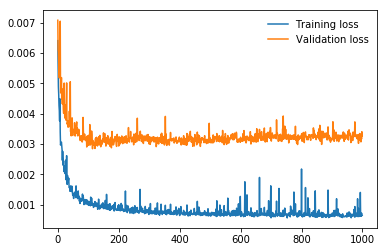

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)


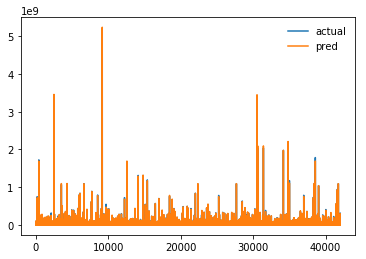

In [21]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [22]:
pred = test_func(model, X_test)

In [23]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.578293e+08
1,BTshNOJyKHnT2YIT,1.796761e+07
2,dhdymr0lV8N5kZOT,3.525607e+07
3,VEwyGGMcD56w5BOc,1.258369e+07
4,wmUeMoJZfsqaSX9b,5.355299e+06
5,EtBjGAHmHCe9t7TZ,1.348479e+07
6,hPNH34vmaZtvBtqc,5.194932e+07
7,wXjeI38bYDMJJwZC,1.772545e+07
8,fxZSGX6aPAFKU8W4,2.273180e+07
9,ewr0Fx6ign87OwaV,2.012924e+07


## overfitting

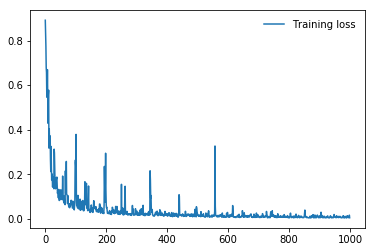

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

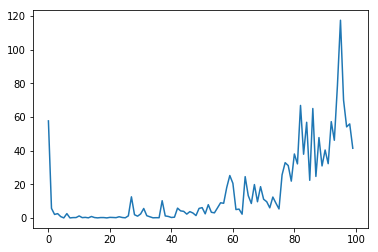

In [19]:
plt.plot(eval_losses, label='Validation loss')


## overfitting2

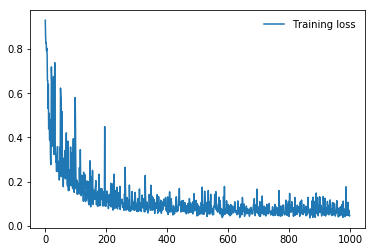

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

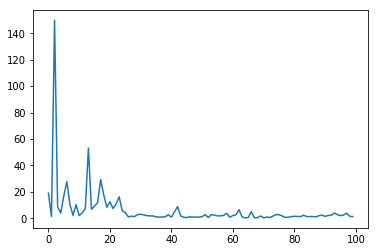

In [19]:
plt.plot(eval_losses, label='Validation loss')


### Submission

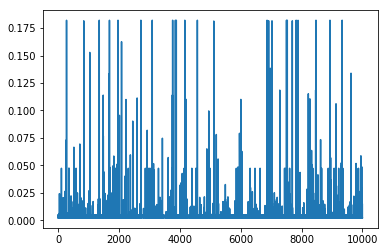

In [26]:
plt.plot(pred, label='pred')


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512